**Imports:**

In [1]:
%reload_ext autoreload
%autoreload 1
from model_files.model import MushroomClassifier,MushroomDataModule, MushroomTuner
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import joblib
import numpy as np
import torch
import pytorch_lightning as ptl
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import model_files.tuning as tunes
from ray import tune
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.search.optuna import OptunaSearch
from ray import train
from sklearn.metrics import classification_report
%aimport model_files.tuning
%aimport model_files.model

**Download the data:**

**Unzip the data and remove redundant files:**

**Settings:**

In [2]:
BASE_FIG_SIZE=(8.5,5)
BASE_DIR = os.getcwd()

## Exploratory Data Analysis

**Setting up a data loader for the eda:**

In [3]:
eda_data_module=MushroomDataModule()
eda_data_module.setup()
eda_loader=eda_data_module.train_dataloader()

### Sample Overview

**Number of samples for each genus:**

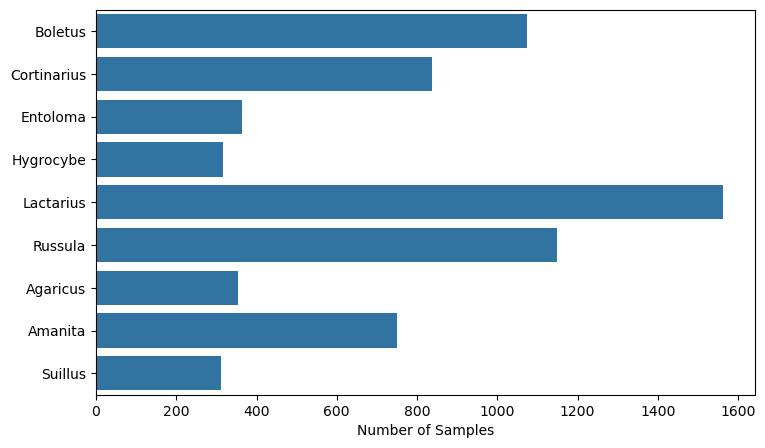

In [4]:
files=os.listdir("Mushrooms")
genuses = [file for file in files]
genus_data_count={}
for genus in genuses:
    pics=os.listdir(f"Mushrooms/{genus}")
    genus_data_count[genus]=len([pic for pic in pics])
genus_data_count
fig_data_count,ax_data_count=plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(genus_data_count,orient='y',ax=ax_data_count)
ax_data_count.set_xlabel("Number of Samples")
plt.show()

**A visual representation of a sample from each class:**

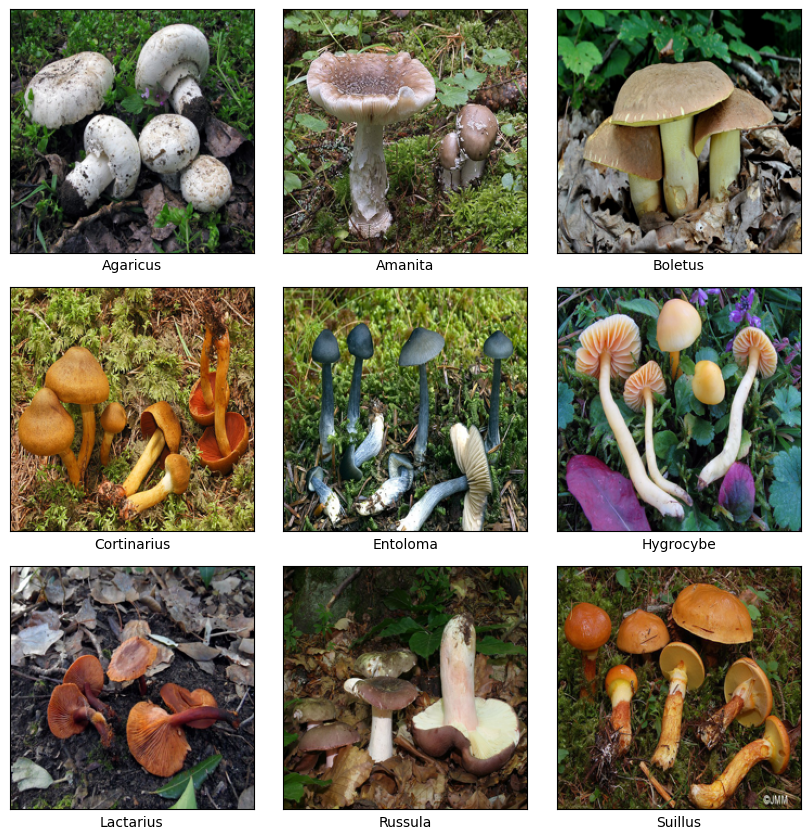

In [5]:
images=pl.DataFrame(eda_loader.dataset.dataset.samples,schema=['path','class'])
class_dict={item:key for key, item in eda_loader.dataset.dataset.class_to_idx.items()}
fig_sample,ax_sample=plt.subplots(3,3,figsize=(BASE_FIG_SIZE[0],BASE_FIG_SIZE[0]))
ax_sample=ax_sample.flatten()
for i in range(9):
    path=images.filter(pl.col("class")==i).sample(1)["path"].item()
    image = Image.open(path)
    image = image.resize((225, 225))
    ax_sample[i].imshow(image)
    ax_sample[i].set_xlabel(class_dict[i])
    ax_sample[i].set_xticks([])
    ax_sample[i].set_yticks([])
plt.tight_layout(w_pad=0.1)

### Image Dimensions

**Getting image dimensions:**

In [6]:
sizes = {}
for genus in genus_data_count.keys():
    sizes[genus] = pl.DataFrame(schema={"name":str, "height":int, "width":int, "channels":int})
    for img_name in os.listdir(f"Mushrooms/{genus}"):
        img = cv2.imread(f"Mushrooms/{genus}/{img_name}")
        height, width, channels = img.shape
        extend_df = pl.DataFrame(
            {"name": img_name, "height": height, "width": width, "channels": channels}
        )
        sizes[genus]=sizes[genus].extend(extend_df)

Premature end of JPEG file


**Image dimension distribution by genus:**

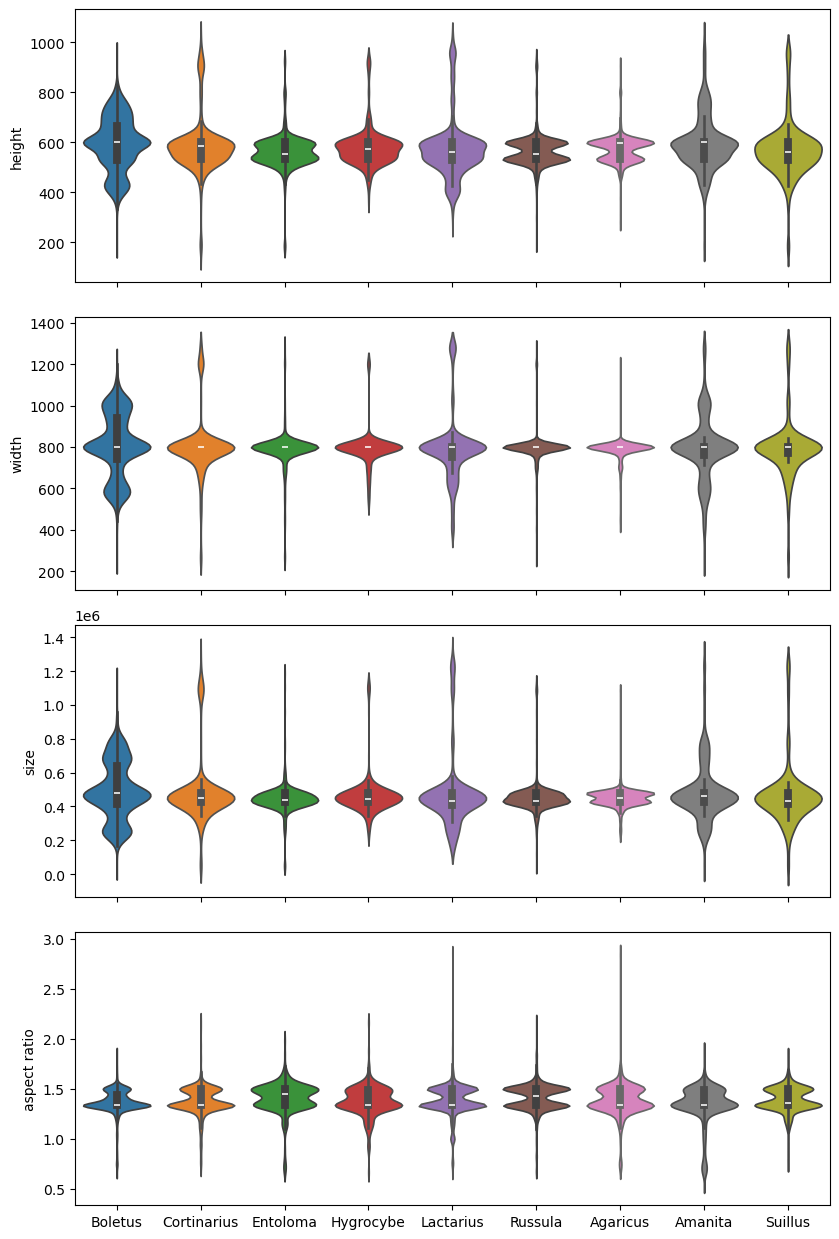

In [7]:
fig_sizes, ax_sizes = plt.subplots(
    4, 1, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2.5), sharex=True
)
for i, genus in enumerate(sizes.keys()):
    sns.violinplot(y=sizes[genus]["height"], x=i, ax=ax_sizes[0])
    sns.violinplot(y=sizes[genus]["width"], x=i, ax=ax_sizes[1])
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("height") * pl.col("width")).alias("size"))
        .to_series(),
        x=i,
        ax=ax_sizes[2],
    )
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("width") / pl.col("height")).alias("aspect ratio"))
        .to_series(),
        x=i,
        ax=ax_sizes[3],
    )

ax_sizes[3].set_xticks(ticks=np.arange(len(sizes)), labels=sizes.keys())
plt.tight_layout()
plt.show()

## Model Setup and Option Trials:

**Setting up a logger for tensorbord:**

In [8]:
tb_logger = ptl.loggers.TensorBoardLogger('logs')

**Early stopping and fine-tunning callback options:**

In [9]:
early_stopping_config = {
    "monitor": "val_loss",
    "patience": 8,
    "mode": "min",
    "min_delta": 0.001,
}
fine_tuning_config = {
    "unfreeze_at_epoch": tune.randint(5, 11),
    "tuning_lr": tune.loguniform(1e-7, 1e-3),
}

**Setting up a trainable for option/hyper-parameter tuning with ray-tune:**

In [10]:
stopper = MaximumIterationStopper(1)
tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(
            tunes.TrainableP2L,
            model=MushroomClassifier,
            dm=MushroomDataModule,
            metric="val_loss",
            logger=tb_logger,
        ),
        resources={"CPU": 2, "GPU": 1},
    ),
    run_config=train.RunConfig(
        stop=stopper,
        storage_path=f"{BASE_DIR}/logs/ray/",
        name="tunning",
        checkpoint_config=train.CheckpointConfig(
            checkpoint_at_end=False,
        ),
    ),
    tune_config=tune.TuneConfig(
        search_alg=OptunaSearch(),
        mode="min",
        metric="score",
        num_samples=50,
    ),
    param_space={
        "batch_size": tune.randint(32, 128),
        "img_size": 224,
        "max_epochs": 22,
        "learning_rate": tune.loguniform(0.00001, 0.01),
        "num_classes": 9,
        "architecture": tune.choice(["squeezenet","resnet18","google","shufflenet"]),
        "optimizer": tune.choice(["adam","sgd"]),
        "l2":tune.loguniform(1e-6,1),
        "early_stopping_params":early_stopping_config,
        "fine_tuning_params":fine_tuning_config,
        "base_dir":BASE_DIR
    },
)

In this single step the best architecture, optimizer, preprocessing and model options are selected. The tuning is performed using ray-tune class API, on a single GPU. 50 trials are run and the best one is selected by the lowest loss (cross entropy). In this stage the options are as follows:

1. Preprocessing:
    * Batch Size 32-128
2. Optimizers:
    * Optimizer: either Adam or Stochastic gradient descent
    * l2 penalty: $1e^{-6}$ to $1$
3. Architectures:
    * ResNet18/SqueezeNet/GoogLeNet
4. Model Parameters:
    * Learning Rate: $1e^{-6}$ to $1e^{-2}$

**Running the option selection procedure:**

**Load results:**

In [12]:
best_params=joblib.load("temp/best_params.joblib")
best_params

{'batch_size': 91,
 'img_size': 224,
 'max_epochs': 22,
 'learning_rate': 0.006614074711373294,
 'num_classes': 9,
 'architecture': 'shufflenet',
 'optimizer': 'adam',
 'l2': 1.9157486673532663e-06,
 'early_stopping_params': {'monitor': 'val_loss',
  'patience': 8,
  'mode': 'min',
  'min_delta': 0.001},
 'fine_tuning_params': {'unfreeze_at_epoch': 9,
  'tuning_lr': 8.250702202020597e-05},
 'base_dir': '/home/gediminas/Documents/turing_projects/module4_s1/gskvar-DL.1.5'}

**View results in tensorboard:**

In [15]:
%load_ext tensorboard

## Model Evaluation

**Initiating model and data module instances with the best parameters:**

In [21]:
best_params['max_epochs']=30
trainer, best_model, best_dm = tunes.config_trainer_model_dm(
    best_params,
    MushroomClassifier,
    MushroomDataModule,
    tb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


**Fitting the model:**

In [22]:
trainer.fit(best_model,best_dm)

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 1.3 M 
1 | model             | Linear     | 9.2 K 
-------------------------------------------------
9.2 K     Trainable params
1.3 M     Non-trainable params
1.3 M     Total params
5.051     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
(trainer.current_epoch - 1) - trainer.callbacks[0].wait_count

20

In [29]:
best_params['max_epochs']=21
trainer, best_model, best_dm = tunes.config_trainer_model_dm(
    best_params,
    MushroomClassifier,
    MushroomDataModule,
    tb_logger,
)
trainer.fit(best_model,best_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 1.3 M 
1 | model             | Linear     | 9.2 K 
-------------------------------------------------
9.2 K     Trainable params
1.3 M     Non-trainable params
1.3 M     Total params
5.051     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=21` reached.


The model was fully trained in 11 epochs, when it was stopped due to no further improvement.

**Testing the model:**

In [30]:
trainer.test(best_model,best_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8376768231391907
        test_loss           0.5016436576843262
 test_weighted_f1_score     0.8384202718734741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5016436576843262,
  'test_accuracy': 0.8376768231391907,
  'test_weighted_f1_score': 0.8384202718734741}]

**Loading test data:**

In [32]:
# best_dm.setup()
test_loader=best_dm.test_dataloader()

**Making prediction on the test set:**

In [33]:
predictions=trainer.predict(best_model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**Moving the predictions and true classes into a data frame:**

In [34]:
predictions_all = torch.cat(predictions, dim=0)
predictions_rounded = torch.argmax(predictions_all, dim=1)
predictions_rounded = pl.DataFrame(predictions_rounded.numpy(), schema=["prediction"])
predictions_rounded = predictions_rounded.with_columns(
    pl.DataFrame(
        [test_loader.dataset.dataset.samples[i] for i in test_loader.dataset.indices]
    )[:, 1].alias("true")
)

**Classification report:**

In [35]:
print(classification_report(predictions_rounded['true'],predictions_rounded['prediction']))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79        71
           1       0.83      0.87      0.85       150
           2       0.89      0.96      0.92       215
           3       0.82      0.75      0.79       167
           4       0.88      0.79      0.83        73
           5       0.90      0.84      0.87        63
           6       0.79      0.90      0.84       313
           7       0.88      0.75      0.81       229
           8       0.80      0.65      0.71        62

    accuracy                           0.84      1343
   macro avg       0.84      0.81      0.82      1343
weighted avg       0.84      0.84      0.84      1343

